# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Webscraping Project 4 Lab

Week 4 | Day 4

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com (or other sites at your team's discretion). In the second part, the focus is on using listings with salary information to build a model and predict high or low salaries and what features are predictive of that result.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver

import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

path_phantom = '//Applications/phantomjs'

In [177]:
## YOUR CODE HERE
driver = webdriver.PhantomJS(executable_path=path_phantom)

In [178]:
soup = BeautifulSoup(driver.page_source, 'lxml')

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above
- Include any other features you may want to use later (e.g. summary, #of reviews...)

In [179]:
## YOUR CODE HERE
def extract_location_from_result(result):
    try:
        location = result.find('span', class_='location').text.strip()
    except:
        location = ''
    return location

def extract_title_from_result(result):
    try:
        job_title = result.find('a', class_='jobtitle').text.strip('\n')
    except:
        try:
            job_title = result.find('h2', class_='jobtitle').text.strip('\n')
        except:
            job_title = ''
    return job_title

def extract_summary_from_result(result):
    try:
        summary = result.find('span', class_='summary').text.strip()
    except:
        summary = ''
    return summary

def extract_company_from_result(result):
    try:
        company = result.find('span', class_='company').text.strip()
    except:
        company = ''
    return company

def extract_reviews_from_result(result):
    try:
        sub = result.find('span', class_='slNoUnderline').text.strip()
        if 'review' in sub:
            reviews = sub.split()[0]
    except:
        reviews = ''
    return reviews

def extract_salary_from_result(result):
    try:
        salary = result.find('td', class_='snip').find('nobr').text.strip()
#         salary_text = salary_text.split()
#         salary = float(salary_text[0].strip('$').replace(',',''))
    except:
        salary = ''
    return salary

def get_all_details(result):
    if extract_salary_from_result(result) != '':
        return [extract_title_from_result(result),\
                extract_company_from_result(result),\
                extract_location_from_result(result),\
                extract_summary_from_result(result),\
                extract_salary_from_result(result)]
    else:
        return 'skip'

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Indeed.com only has salary information for an estimated 20% of job postings. You may want to add other cities to the list below to gather more data. 
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [180]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 800
results = []

In [181]:
for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Atlanta']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        full_url = url_template.format(city, start)
        driver.get(full_url)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        # Append to the full set of results
        for item in soup.findAll('div', class_='result'):
            if get_all_details(item) != 'skip':
                results.append(get_all_details(item))
#         pass

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [182]:
df = pd.DataFrame(results, columns=['title', 'company', 'location', 'summary', 'salary'])

In [183]:
df.shape

(244, 5)

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [184]:
df['rate'] = df['salary'].map(lambda x: (40*50) if 'hour' in x else 12 if 'month' in x else 1)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [185]:
## YOUR CODE HERE
def get_salary_amount(salary_string):
    try:
        salary_string.replace('-', ' ')
        sal_list = salary_string.split()
        figures = []
        for i in sal_list:
            try:
#                 print i.strip('$')
                figures.append(float(i.strip('$').replace(',','')))
            except:
                pass
#         print figures
        return (np.mean(figures))
    except:
        return np.nan

In [186]:
df['est_sal_per_unit_time'] = df['salary'].map(get_salary_amount)

In [187]:
df['est_annual_sal'] = df['est_sal_per_unit_time']*df['rate']

In [188]:
df.head()

,title,company,location,summary,salary,rate,est_sal_per_unit_time,est_annual_sal
0,Machine Learning Engineer,Workbridge Associates,"San Francisco, CA",This person will be working alongside the Data...,"$120,000 - $150,000 a year",1,135000.0,135000.0
1,Senior Data Scientist,Workbridge Associates,"San Francisco, CA",A leading healthcare start up is looking to br...,"$150,000 - $180,000 a year",1,165000.0,165000.0
2,"Data Science Resident (DSR), and gU Resident",Galvanize,"San Francisco, CA","As part of the Residency program, you will rec...","$1,250 a week",1,1250.0,1250.0
3,Lead Data Scientist (Life Sciences),Workbridge Associates,"San Francisco, CA",A leading technology company is looking for Da...,"$150,000 - $180,000 a year",1,165000.0,165000.0
4,Associate Scientist,Hart,"South San Francisco, CA",Communicates data and interpretation to work g...,$30 an hour,2000,30.0,60000.0


In [189]:
df.describe()

,rate,est_sal_per_unit_time,est_annual_sal
count,244.000000,244.000000,244.000000
mean,135.823770,68255.915471,96132.463115
std,494.873977,64939.377613,44278.388283
min,1.000000,15.500000,886.000000
25%,1.000000,6500.000000,73928.875000
50%,1.000000,65000.000000,78000.000000
75%,12.000000,115748.500000,117453.125000
max,2000.000000,250000.000000,250000.000000


### Save your results as a CSV

In [190]:
## YOUR CODE HERE

In [191]:
df2 = df.copy()
df2 = df2.drop(['salary', 'rate', 'est_sal_per_unit_time'], axis=1)

In [192]:
df2.to_csv('indeed.csv', encoding='utf-8')

In [2]:
df2 = pd.read_csv('indeed.csv')

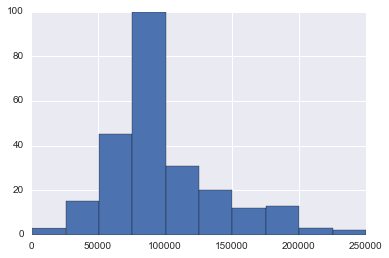

In [3]:
df2.est_annual_sal.hist() 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
vectorizer = CountVectorizer(ngram_range=(1,5),\
                            stop_words='english',\
                            max_features=1000,\
                            binary=True)

In [31]:
vectorizer.fit(df2['summary'])

CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [32]:
summary_features = vectorizer.transform(df2['summary'])

In [33]:
summary_features

<244x1000 sparse matrix of type '<type 'numpy.int64'>'
	with 7784 stored elements in Compressed Sparse Row format>

In [34]:
df2['high_sal'] = df2['est_annual_sal'].map(lambda x: 1 if x > df2['est_annual_sal'].median() else 0)

In [35]:
y = df2['high_sal']

In [55]:
df2['sal_range'] = df2['est_annual_sal'].map(lambda x: 2 if x >\
                                             df2['est_annual_sal'].median()+2*df2['est_annual_sal'].std() else\
                                            1 if x > df2['est_annual_sal'].median()-df2['est_annual_sal'].std()\
                                            else 0)

In [56]:
df2.head()

,Unnamed: 0,title,company,location,summary,est_annual_sal,high_sal,sal_range
0,0,Machine Learning Engineer,Workbridge Associates,"San Francisco, CA",This person will be working alongside the Data...,135000.0,1,1
1,1,Senior Data Scientist,Workbridge Associates,"San Francisco, CA",A leading healthcare start up is looking to br...,165000.0,1,1
2,2,"Data Science Resident (DSR), and gU Resident",Galvanize,"San Francisco, CA","As part of the Residency program, you will rec...",1250.0,0,0
3,3,Lead Data Scientist (Life Sciences),Workbridge Associates,"San Francisco, CA",A leading technology company is looking for Da...,165000.0,1,1
4,4,Associate Scientist,Hart,"South San Francisco, CA",Communicates data and interpretation to work g...,60000.0,0,1


In [57]:
from sklearn.linear_model import LogisticRegressionCV

In [58]:
y = df2['sal_range']
logreg = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='lbfgs')
model = logreg.fit(summary_features, y)
predicted = model.predict(summary_features)

In [59]:
results = pd.DataFrame([y,predicted], index = ['actual', 'predicted']).T

In [60]:
results['match'] = results['actual'] == results['predicted']

In [61]:
model.score(summary_features, y)

1.0

In [62]:
model.get_params

<bound method LogisticRegressionCV.get_params of LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)>

In [63]:
y

0      1
1      1
2      0
3      1
4      1
5      1
6      2
7      1
8      1
9      2
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
214    2
215    1
216    1
217    1
218    1
219    1
220    1
221    1
222    1
223    2
224    1
225    1
226    1
227    1
228    1
229    1
230    1
231    2
232    1
233    1
234    1
235    1
236    1
237    1
238    1
239    1
240    1
241    1
242    1
243    0
Name: sal_range, dtype: int64

In [64]:
feature_imp = pd.DataFrame([vectorizer.get_feature_names(), model.coef_.tolist()[0]], index=['features', 'coef']).T

feature_imp.sort_values(by='coef', ascending=False).head()

,features,coef
549,managing,2.94407
813,responsible,2.22959
286,development data,1.62624
361,faculty,1.1066
722,program,1.09317


In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [86]:
tv = TfidfVectorizer(ngram_range=(1,5),\
                            stop_words='english',\
                            max_features=1000,\
                            binary=True)

In [87]:
X2 = tv.fit_transform(df2['summary'])

In [88]:
logreg2 = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='lbfgs')
model2 = logreg2.fit(X2, y)
predicted = model.predict(X2)

In [89]:
model2.score(X2, y)

1.0

In [90]:
feature_imp2 = pd.DataFrame([tv.get_feature_names(), model2.coef_.tolist()[0]], index=['features', 'coef']).T

feature_imp2.sort_values(by='coef', ascending=False).head()

,features,coef
549,managing,5.77044
286,development data,4.9468
813,responsible,4.1983
739,provider,3.30627
378,fortune,3.18399


In [68]:
from sklearn.cross_validation import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(summary_features,y,test_size=0.2, stratify=y)

In [71]:
lr2 = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='lbfgs')
m2 = lr2.fit(X_train, y_train)

//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [72]:
p2 = m2.predict_proba(X_test)

In [82]:
check = pd.DataFrame(p2, columns=['p_low', 'p_medium','p_high'])

In [76]:
m2.score(X_test, y_test)

0.8571428571428571

In [83]:
check['actaul'] = np.array(y_test)

In [84]:
check.head()

,p_low,p_medium,p_high,actaul
0,0.001443,0.984454,0.014103,1
1,0.000318,0.999432,0.000250,1
2,0.000162,0.999721,0.000117,1
3,0.000015,0.999977,0.000009,1
4,0.000004,0.999994,0.000003,1


In [217]:
check['p_high_2'] = check['p_high'].map(lambda x: 1 if x > 0.5 else 0)

In [218]:
check.head(10)

,p_low,p_high,high_sal,p_high_2
0,0.997098,0.002902,0,0
1,0.997098,0.002902,0,0
2,0.943380,0.056620,0,0
3,0.336774,0.663226,1,1
4,0.611941,0.388059,0,0
5,0.997098,0.002902,0,0
6,0.997098,0.002902,0,0
7,0.048309,0.951691,1,1
8,0.591519,0.408481,1,0
9,0.997098,0.002902,0,0


In [219]:
len(check[check['high_sal'] == check['p_high_2']])

43

In [220]:
check['p'] = m2.predict(X_test)

In [221]:
len(check[check['high_sal'] == check['p']])

43

In [223]:
len(check)

49

In [235]:
test = vectorizer.get_feature_names()

In [252]:
from wordcloud import WordCloud, ImageColorGenerator

(-0.5, 399.5, 199.5, -0.5)

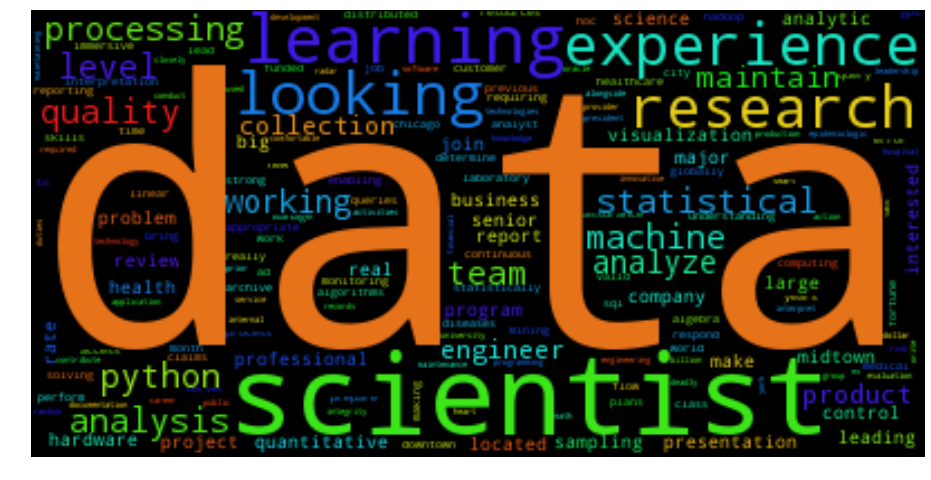

In [243]:
wordcloud = WordCloud().generate(' '.join(test))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")

In [248]:
from wordcloud import get_single_color_func

In [249]:
get_single_color_func('white')

<function wordcloud.wordcloud.single_color_func>

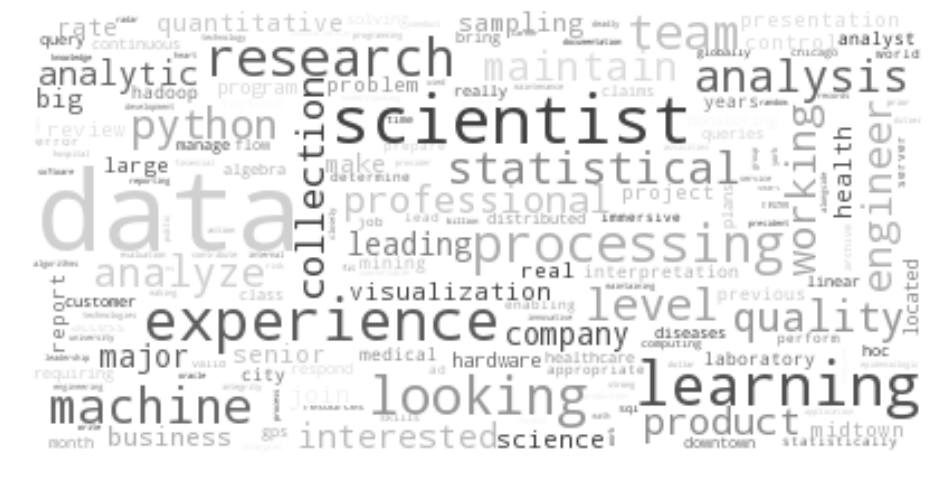

In [251]:
wordcloud = WordCloud(max_font_size=50, relative_scaling=.5, background_color='white',\
                      color_func=get_single_color_func('black')).generate(' '.join(test))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# testing out Glassdoor API


<a href='https://www.glassdoor.com/index.htm'>powered by <img src='https://www.glassdoor.com/static/img/api/glassdoor_logo_80.png' title='Job Search' /></a>

In [100]:
g = webdriver.PhantomJS(executable_path=path_phantom)


In [101]:
g.get('https://www.glassdoor.com/Salaries/data-scientist-salary-SRCH_KO0,14.htm')

In [102]:
s = BeautifulSoup(g.page_source, 'lxml')

In [103]:
print s.prettify()

<!DOCTYPE html>
<html>
 <head>
  <title>
   Pardon Our Interruption
  </title>
  <link href="//cdn.distilnetworks.com/css/distil.css" media="all" rel="stylesheet" type="text/css"/>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="width=1000" name="viewport"/>
  <meta content="noindex, nofollow" name="robots"/>
  <meta content="max-age=0" http-equiv="cache-control"/>
  <meta content="no-cache" http-equiv="cache-control"/>
  <meta content="0" http-equiv="expires"/>
  <meta content="Tue, 01 Jan 1980 1:00:00 GMT" http-equiv="expires"/>
  <meta content="no-cache" http-equiv="pragma"/>
  <script defer="" src="/glass.qqqqtrv.js" type="text/javascript">
  </script>
  <style type="text/css">
   #d__fFH{position:absolute;top:-5000px;left:-5000px}#d__fF{font-family:serif;font-size:200px;visibility:hidden}#zdutyzrsqqtszutb{display:none!important}
  </style>
  <style type="text/css">
   #dCF_input_complete { 
		display: inline-block;
		margin-bottom: 0;
		font